In [1]:
from datetime import datetime, timezone

import numpy as np

from lib import load_dataset
df = load_dataset(latitude=51.352139, longitude=6.622948, elevation=32.8, start=datetime(year=2025, month=3, day=1, tzinfo=timezone.utc))

In [2]:
full = df['level'] > 98
df['yield'] = df['yield'].where(~full)
df = df.drop(['level'], axis=1)

<Axes: >

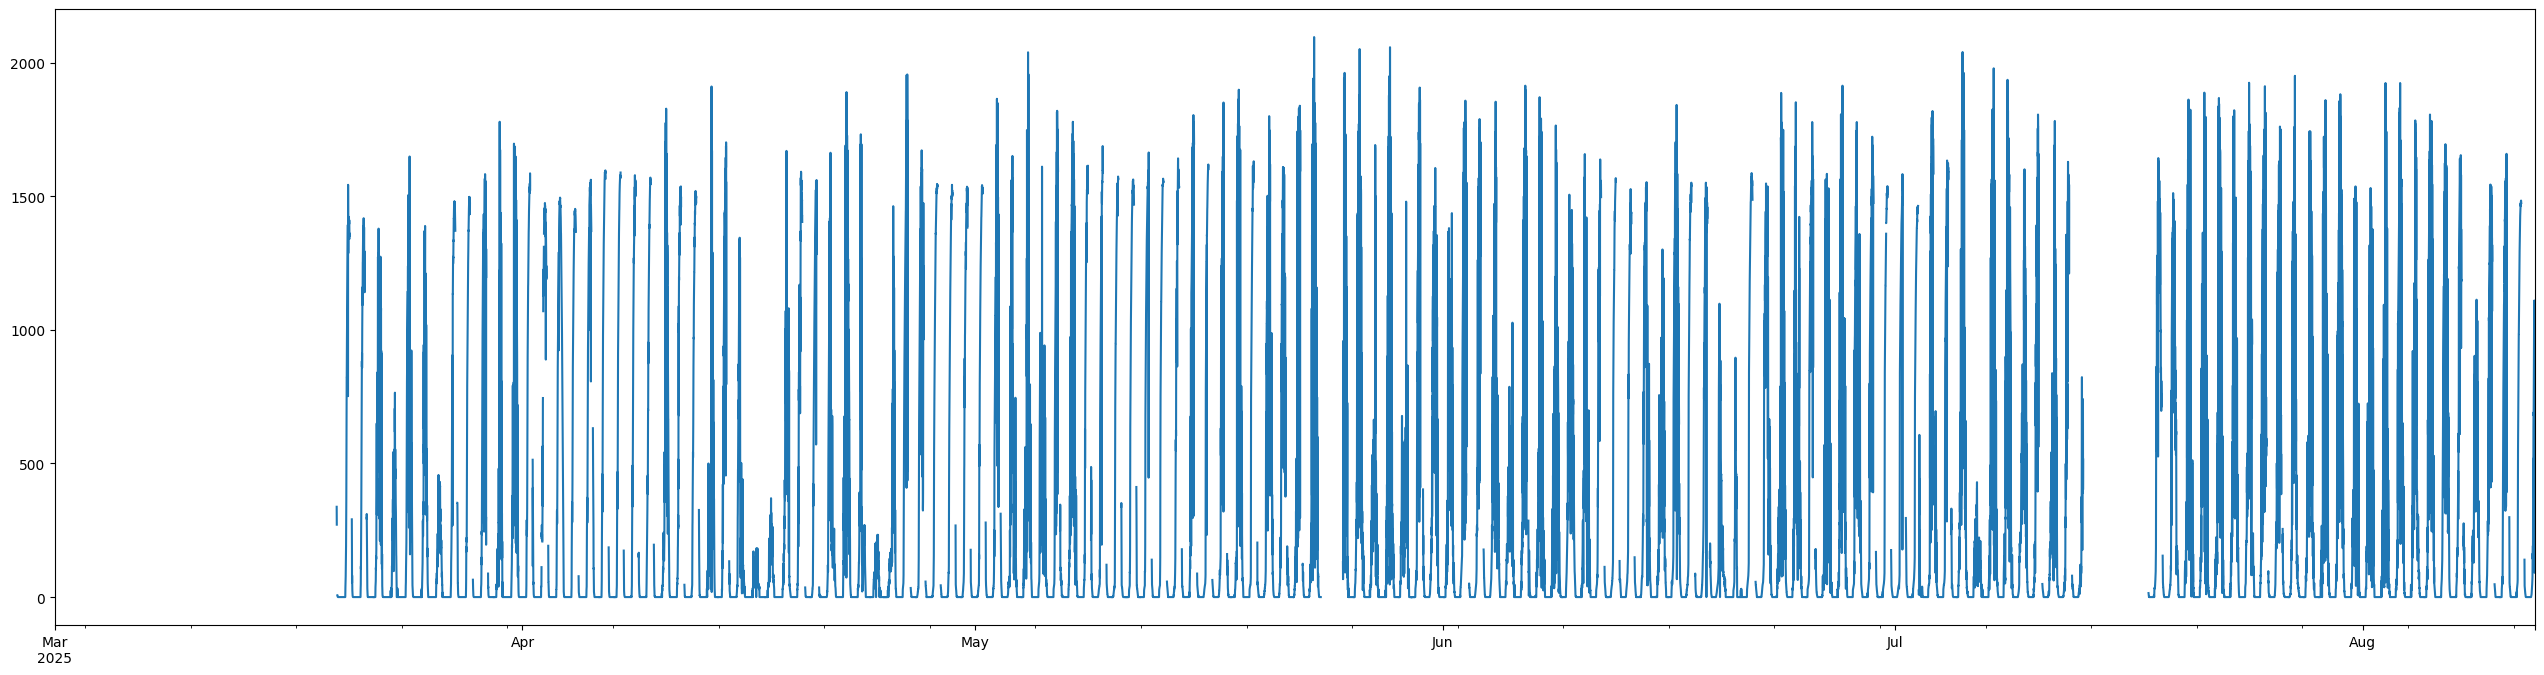

In [3]:
df['yield'].plot(figsize = (32, 8))

<Axes: >

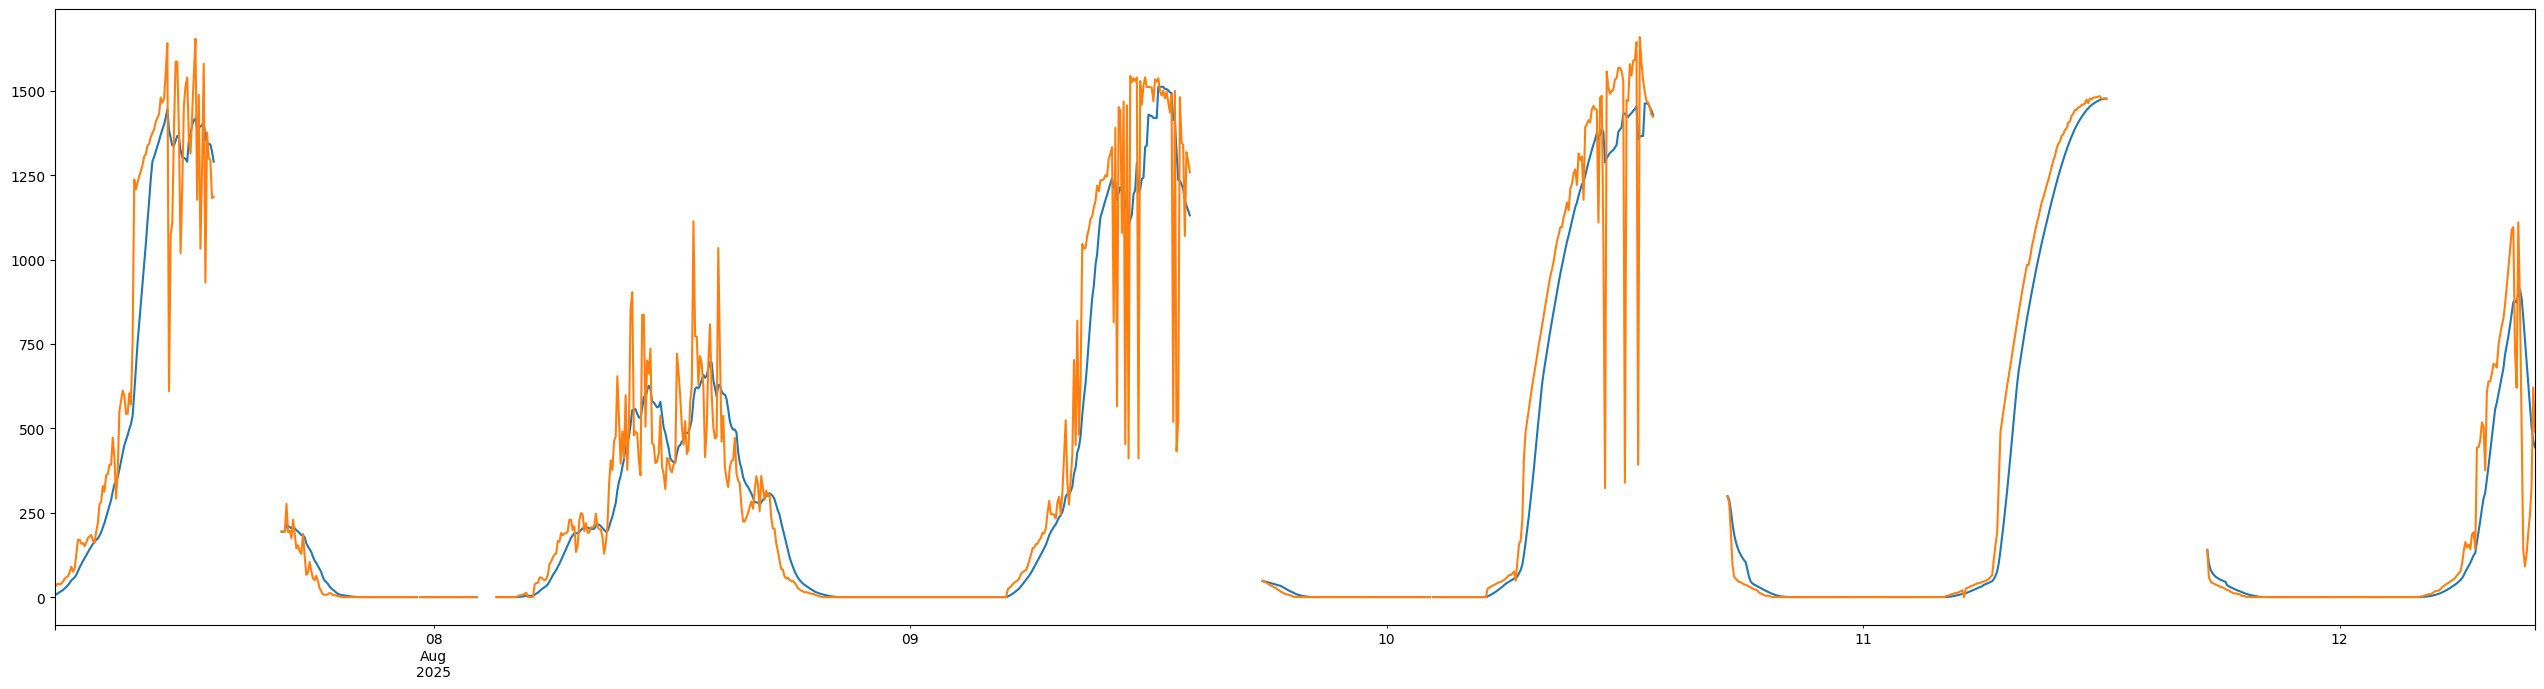

In [4]:
df['yield_rolling_avg'] = df['yield'].rolling(window=12, min_periods=1).mean()
df['yield_rolling_avg'] = df['yield_rolling_avg'].where(~df['yield'].isna())
df['yield_rolling_avg'].tail(1500).plot(figsize = (32, 8))
df['yield'].tail(1500).plot(figsize = (32, 8))

## Split dataframe into nan and non-nan chunks

This section splits the DataFrame into chunks based on NaN values in the 'yield' column:

1. Create a boolean mask identifying NaN values in 'yield' column
2. Detect changes in the mask using the `ne()` (not equal) comparison with shifted values
3. Create groups using cumulative sum of the changes 
4. Split dataframe into separate chunks based on these groups

This allows separating data into segments where 'yield' values are either all NaN or all non-NaN.


In [5]:
mask = df['yield'].isna()
change = mask.ne(mask.shift(fill_value=mask.iloc[0]))
group_ids = change.cumsum()
dfs = [g for _, g in df.groupby(group_ids, sort=False)]

In [54]:
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
from xgboost import XGBRegressor

def build_forecaster(window_length=10, random_state=42):
    reg = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=1,   # stabil bei CV; kann später erhöht werden
    )
    forecaster = TransformedTargetForecaster(steps=[
        ("diff", Differencer(lags=1)),
        ("regr", make_reduction(
            estimator=reg,
            strategy="recursive",
            window_length=window_length
        )),
    ])
    return forecaster

base_forecaster = build_forecaster()

# Initialize Training with Non-NaN Data Block

Before starting the training process, we need to identify the first block of data that contains no missing values (NaN) in the yield column. The next cell uses `dropwhile` to:

1. Filter out initial data blocks containing NaN values
2. Start with the first complete block of data for training
3. Prepare for sequential model updates with subsequent data blocks

This ensures our initial model training begins with clean, complete data.


In [55]:
import pandas as pd
predictions = None
for d in dfs:
    y = d['yield']
    X = d.drop(['yield'], axis=1)
    print(X.index)
    print(y.index)
    if not d['yield'].isna().any():
        if base_forecaster.is_fitted:
            base_forecaster.update(y=y, X=X)
        else:
            if len(d) > 12:
                base_forecaster.fit(X=X, y=y)
                print(base_forecaster.cutoff)
    else:
        if base_forecaster.is_fitted:
            if predictions is None:
                predictions = base_forecaster.predict(X=X, fh=len(d))
            else:
                predictions = predictions.concat([base_forecaster.predict(X=X, fh=len(d))])

predictions

DatetimeIndex(['2025-03-19 17:40:00+00:00', '2025-03-19 17:45:00+00:00',
               '2025-03-19 17:50:00+00:00', '2025-03-19 17:55:00+00:00',
               '2025-03-19 18:00:00+00:00', '2025-03-19 18:05:00+00:00',
               '2025-03-19 18:10:00+00:00', '2025-03-19 18:15:00+00:00',
               '2025-03-19 18:20:00+00:00', '2025-03-19 18:25:00+00:00',
               ...
               '2025-03-20 12:15:00+00:00', '2025-03-20 12:20:00+00:00',
               '2025-03-20 12:25:00+00:00', '2025-03-20 12:30:00+00:00',
               '2025-03-20 12:35:00+00:00', '2025-03-20 12:40:00+00:00',
               '2025-03-20 12:45:00+00:00', '2025-03-20 12:50:00+00:00',
               '2025-03-20 12:55:00+00:00', '2025-03-20 13:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=233, freq='5min')
DatetimeIndex(['2025-03-19 17:40:00+00:00', '2025-03-19 17:45:00+00:00',
               '2025-03-19 17:50:00+00:00', '2025-03-19 17:55:00+00:00',
               '2025-03-19 18:00:00+

ValueError: Inferred frequency None from passed values does not conform to passed frequency 5min

In [38]:
for d in dfs:
    print((d['yield'].index.freq))

<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * Minutes>
<5 * M